In [173]:
import numpy as np
import pandas as pd
import fipy as fp
from matplotlib import pyplot as plt
from matplotlib import cm
import os
import re
import pdb
import h5py
import lncrna_analysis_helper as lh
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

## Protein partition coefficient in dense phase vs. protein concentration for different cases

In [174]:
def calculate_protein_in_condensate(phi_p_0_list, target_directory, name_pattern, 
                                    stats_file = 'stats.txt', param_file='input_params.txt', 
                                    spatial_variables_file='spatial_variables.hdf5', nx = 300, dx = 0.1):
    
    protein_in_enhancer = np.zeros(len(phi_p_0_list))
    
    for i in range(len(phi_p_0_list)):
    
        pattern = name_pattern.format(phi_p=phi_p_0_list[i])

        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:

                stats_file_name = root + '/' + stats_file
                df_stats = pd.read_csv(stats_file_name, '\t')
                times = df_stats['t']

                # Read values of input parameters from param_file
                input_param_file = root + '/' + param_file
                input_parameters = lh.input_parse(input_param_file)

                if input_parameters['nx'] != nx or input_parameters['dx'] != dx:
                    nx = input_parameters['nx']
                    dx = input_parameters['dx']

                mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                
                indices_enhancer_well = (mesh.x+0.5*input_parameters['rna_nucleus_distance_to_protein'])**2 + mesh.y**2 - 0.5*input_parameters['sigma']**2 < 0
                
                spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file

                with h5py.File(spatial_variable_hdf5_file_name) as sp_f:

                    phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][-1])

                    protein_in_enhancer[i] = np.sum(phi_p.value[indices_enhancer_well]*mesh.cellVolumes[indices_enhancer_well])/np.sum(mesh.cellVolumes[indices_enhancer_well]) 

    return protein_in_enhancer

In [175]:
phi_p_0_list = [0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]

target_directory = '/nfs/arupclab001/npradeep96/PhaseField/LNCRNA_RESCUES_CONDENSATE/'

name_pattern_no_lncrna = "phi_p0_{phi_p}_.*_L_P_0.0_.*_M_rna_1.0$"
protein_in_enhancer_no_lncrna = calculate_protein_in_condensate(phi_p_0_list=phi_p_0_list, target_directory=target_directory, name_pattern=name_pattern_no_lncrna)

name_pattern_lncrna = "phi_p0_{phi_p}_.*_L_P_4.0_.*_M_rna_1.0$"
protein_in_enhancer_lncrna = calculate_protein_in_condensate(phi_p_0_list=phi_p_0_list, target_directory=target_directory, name_pattern=name_pattern_lncrna)

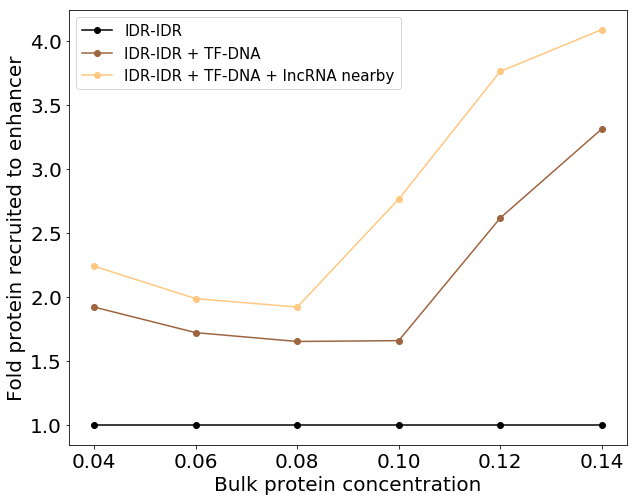

In [171]:
colors = cm.get_cmap('copper', 3)
color_values = np.linspace(0.0,1.0,3)

fig,axs = plt.subplots(1,1,figsize=(10,8))

axs.plot(phi_p_0_list, np.ones(len(phi_p_0_list)), '-o', label="IDR-IDR", c=colors(color_values[0]))
axs.plot(phi_p_0_list, np.divide(protein_in_enhancer_no_lncrna,phi_p_0_list), '-o', label="IDR-IDR + TF-DNA", c=colors(color_values[1]))
axs.plot(phi_p_0_list, np.divide(protein_in_enhancer_lncrna,phi_p_0_list), '-o', label="IDR-IDR + TF-DNA + lncRNA nearby", c=colors(color_values[2]))

axs.set_xlabel('Bulk protein concentration',fontsize=20)
axs.set_ylabel('Fold protein recruited to enhancer',fontsize=20)
axs.legend(fontsize=15)
plt.savefig("20211215 - Plots for joint meeting/lncRNA_cooperativity.svg", format='svg', dpi=1200)
plt.show()

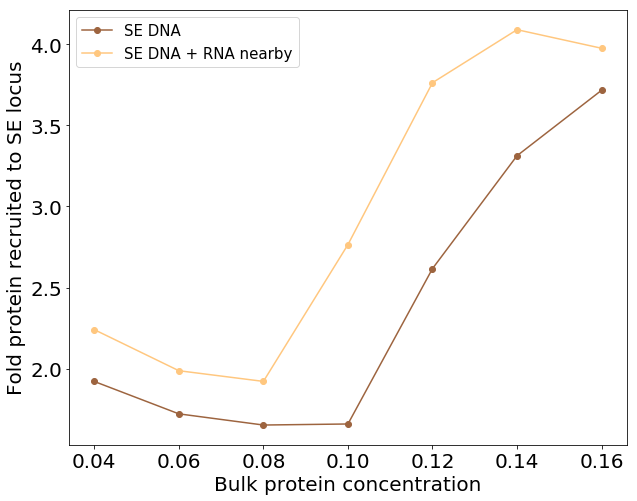

In [177]:
colors = cm.get_cmap('copper', 3)
color_values = np.linspace(0.0,1.0,3)

fig,axs = plt.subplots(1,1,figsize=(10,8))

# axs.plot(phi_p_0_list, np.ones(len(phi_p_0_list)), '-o', label="IDR-IDR", c=colors(color_values[0]))
axs.plot(phi_p_0_list, np.divide(protein_in_enhancer_no_lncrna,phi_p_0_list), '-o', label="SE DNA", c=colors(color_values[1]))
axs.plot(phi_p_0_list, np.divide(protein_in_enhancer_lncrna,phi_p_0_list), '-o', label="SE DNA + RNA nearby", c=colors(color_values[2]))

axs.set_xlabel('Bulk protein concentration',fontsize=20)
axs.set_ylabel('Fold protein recruited to SE locus',fontsize=20)
axs.legend(fontsize=15)
plt.savefig("20220202 - Plots for joint meeting/lncRNA_cooperativity.svg", format='svg', dpi=1200)
plt.show()

## Dynamics of condensate and gene expression dynamics

In [106]:
def calculate_dynamics(kpl_list, target_directory, name_pattern, 
                       dynamical_trajectory_file = 'dynamical_trajectories.hdf5', 
                       param_file='input_params.txt'):
    
    protein_in_enhancer = np.zeros(len(phi_p_0_list))
    
    times, protein, mrna_rate = list(), list(), list()
    
    for i in range(len(kpl_list)):
    
        pattern = name_pattern.format(kpl=kpl_list[i])

        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:
                
                # Read values of input parameters from param_file
                input_param_file = root + '/' + param_file
                input_parameters = lh.input_parse(input_param_file)

                dynamical_trajectories = root + '/' + dynamical_trajectory_file
                
                with h5py.File(dynamical_trajectories) as sp_f:
                    
                    times.append(input_parameters['k_degradation']*sp_f['t'][:])
                    protein.append(sp_f['average_protein_in_enhancer_well'][:]/input_parameters['phi_p_0'])
                    mrna_rate.append(sp_f['net_rate_of_mrna_increase'][:]/(input_parameters['k_p_max']*0.5*np.pi*input_parameters['sigma']**2*input_parameters['phi_p_0']))

    return times, protein, mrna_rate

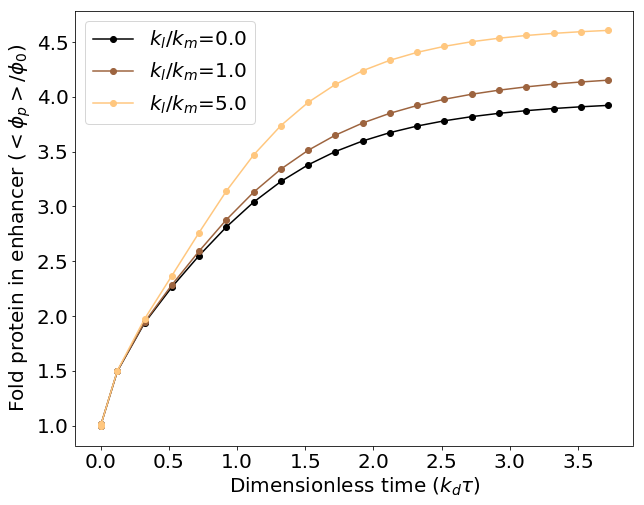

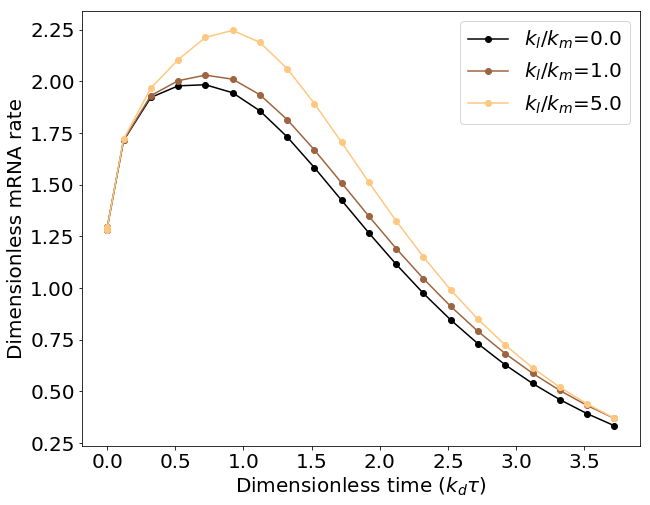

In [113]:
kpl_list = [0.00, 0.001, 0.005]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA//'
name_pattern_lncrna = "_k_p_lncRNA_{kpl}_.*_k_p_0.001_.*M_rna_0.01$"
times, protein, mrna_rate = calculate_dynamics(kpl_list=kpl_list, target_directory=target_directory, name_pattern=name_pattern_lncrna)

fig,axs = plt.subplots(1,1,figsize=(10,8))
colors = cm.get_cmap('copper', len(kpl_list))
color_values = np.linspace(0.0,1.0,len(kpl_list))

for i in range(len(times)):
    axs.plot(times[i], protein[i], '-o', label="$k_{l}/k_{m}$" +"={kpl}".format(kpl=kpl_list[i]/0.001), c = colors(color_values[i]))
    
axs.set_ylabel("Fold protein in enhancer ($<\phi_p>/\phi_0$)", fontsize=20)
axs.set_xlabel("Dimensionless time ($k_d\\tau$)", fontsize=20)
axs.legend(fontsize=20)

plt.savefig("20211215 - Plots for joint meeting/protein_dynamics_1.svg", format='svg', dpi=1200)
plt.show()

fig,axs = plt.subplots(1,1,figsize=(10,8))
colors = cm.get_cmap('copper', len(kpl_list))
color_values = np.linspace(0.0,1.0,len(kpl_list))

for i in range(len(times)):
    axs.plot(times[i], mrna_rate[i], '-o', label="$k_{l}/k_{m}$" +"={kpl}".format(kpl=kpl_list[i]/0.001), c = colors(color_values[i]))
    
axs.set_ylabel("Dimensionless mRNA rate", fontsize=20)
axs.set_xlabel("Dimensionless time ($k_d\\tau$)", fontsize=20)
axs.legend(fontsize=20)

plt.savefig("20211215 - Plots for joint meeting/mrna_dynamics_1.svg", format='svg', dpi=1200)
plt.show()

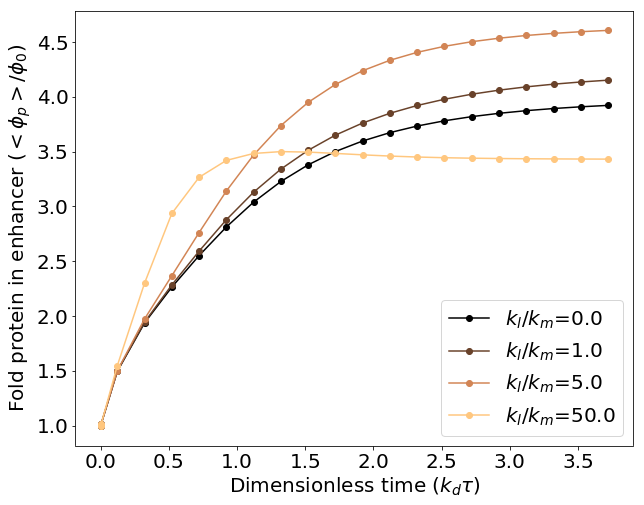

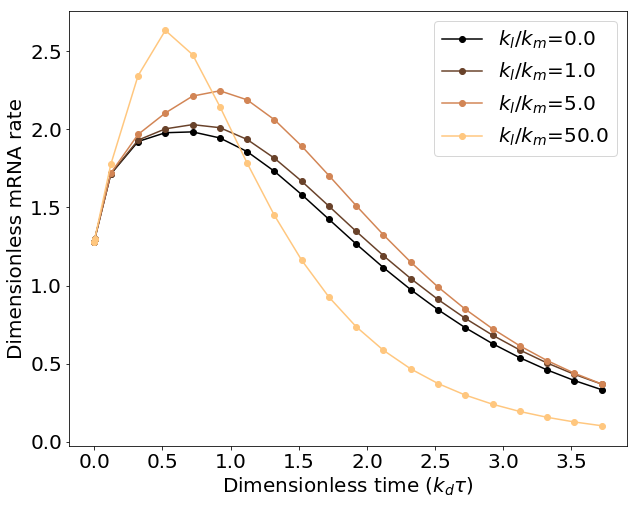

In [112]:
kpl_list = [0.00, 0.001, 0.005, 0.05]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA//'
name_pattern_lncrna = "_k_p_lncRNA_{kpl}_.*_k_p_0.001_.*M_rna_0.01$"
times, protein, mrna_rate = calculate_dynamics(kpl_list=kpl_list, target_directory=target_directory, name_pattern=name_pattern_lncrna)

fig,axs = plt.subplots(1,1,figsize=(10,8))
colors = cm.get_cmap('copper', len(kpl_list))
color_values = np.linspace(0.0,1.0,len(kpl_list))

for i in range(len(times)):
    axs.plot(times[i], protein[i], '-o', label="$k_{l}/k_{m}$" +"={kpl}".format(kpl=kpl_list[i]/0.001), c = colors(color_values[i]))
    
axs.set_ylabel("Fold protein in enhancer ($<\phi_p>/\phi_0$)", fontsize=20)
axs.set_xlabel("Dimensionless time ($k_d\\tau$)", fontsize=20)
axs.legend(fontsize=20)

plt.savefig("20211215 - Plots for joint meeting/protein_dynamics_2.svg", format='svg', dpi=1200)
plt.show()

fig,axs = plt.subplots(1,1,figsize=(10,8))
colors = cm.get_cmap('copper', len(kpl_list))
color_values = np.linspace(0.0,1.0,len(kpl_list))

for i in range(len(times)):
    axs.plot(times[i], mrna_rate[i], '-o', label="$k_{l}/k_{m}$" +"={kpl}".format(kpl=kpl_list[i]/0.001), c = colors(color_values[i]))
    
axs.set_ylabel("Dimensionless mRNA rate", fontsize=20)
axs.set_xlabel("Dimensionless time ($k_d\\tau$)", fontsize=20)
axs.legend(fontsize=20)

plt.savefig("20211215 - Plots for joint meeting/mrna_dynamics_2.svg", format='svg', dpi=1200)
plt.show()

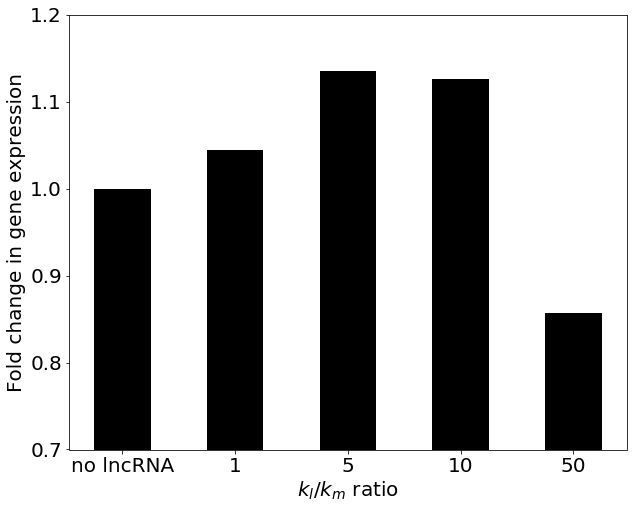

In [169]:
#### Plotting fold change in mRNA amounts with kl

kpl_list = [0.00, 0.001, 0.005, 0.01, 0.05]

target_directory = '/nfs/arupclab001/npradeep96/PhaseField/ACTIVE_MRNA_LNCRNA//'
name_pattern_lncrna = "_k_p_lncRNA_{kpl}_.*_k_p_0.001_.*M_rna_0.01$"
times, protein, mrna_rate = calculate_dynamics(kpl_list=kpl_list, target_directory=target_directory, name_pattern=name_pattern_lncrna)

fold_change_gene_expression = np.zeros(len(kpl_list))

for i in range(len(kpl_list)):
    fold_change_gene_expression[i] = np.trapz(mrna_rate[i].transpose(), times[i].transpose())
    
fold_change_gene_expression = fold_change_gene_expression/fold_change_gene_expression[0]
    
fig,axs = plt.subplots(1,1,figsize=(10,8))
colors = cm.get_cmap('copper', len(kpl_list))
color_values = np.linspace(0.0,1.0,len(kpl_list))

labels = ["", "no lncRNA", "1", "5", "10", "50"]
X = np.arange(len(labels)-1)

axs.bar(X, fold_change_gene_expression, color = colors(color_values[0]), width=0.5)
axs.set_ylim([0.7,1.2])
axs.set_xticklabels(labels)
axs.set_xlabel('$k_l/k_m$ ratio', fontsize = 20)
axs.set_ylabel('Fold change in gene expression', fontsize = 20)
plt.savefig("20211215 - Plots for joint meeting/steady_state_gene_expression.svg", format='svg', dpi=1200)
plt.show()
    